<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.1 MB/s eta 0:00:00


In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install wordcloud

Looking in indexes: https://download.pytorch.org/whl/cu117, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import torch
import time

from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Загрузим и сохраним данные
data=pd.read_csv('/content/toxic_comments.csv', index_col=0)

In [5]:
# создадим функцию для первоначального анализа данных
def df_info(dataframe):
    column = dataframe.columns.values.tolist() # список наименований столбцов таблицы
    print('Общая информация о таблице:\n')
    dataframe.info() # общая информация о таблице
    print('\nВнешний вид таблицы :')
    display(dataframe.sample()) # внешний вид первых 5 строк таблицы

    # далее выводим все интересующие нас особенности таблицы, соответствнно, обозначенные в функции print()
    print('Столбцы таблицы: {}\n'.format(column),
          '\n\nОбщее количество уникальных значений столбцов {}:\n\n{}'.
          format(column, dataframe.nunique()),
          '\n\nКоличество пропущенных значений столбцов {}:\n\n{}'.
          format(column, dataframe.isna().sum()))
    
    for i in column: # создадим цикл для перебора значений столбцов для отдельного примнения к ним любой функции
          print('\n\nСоотношение дубликатов столбца {} ко всем строкам:\t {}'.format(i, dataframe[i].duplicated().mean()/len(dataframe)))
    print('\nСоотношение явных дубликтов ко всем строкам: {}'.format((dataframe.duplicated().mean()/len(dataframe))))
    print('\n\nТаблица корреляций значений столбцов {}:\n\n{}'.format(column, dataframe.corr()), '\n',
          '\n\nТаблица распределений значений столбцов {}:\n\n{}'.format(column, dataframe.describe()), '\n')
    print('Гистограммы распределений значений столбцов {}'.format(column))
    dataframe.hist(bins=10, figsize=(10, 5), edgecolor = 'k')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

Внешний вид таблицы :


,text,toxic
147910,"""\n\n importance \n\nIn general, articles are ...",0


Столбцы таблицы: ['text', 'toxic']
 

Общее количество уникальных значений столбцов ['text', 'toxic']:

text     159292
toxic         2
dtype: int64 

Количество пропущенных значений столбцов ['text', 'toxic']:

text     0
toxic    0
dtype: int64


Соотношение дубликатов столбца text ко всем строкам:	 0.0


Соотношение дубликатов столбца toxic ко всем строкам:	 6.27770035181713e-06

Соотношение явных дубликтов ко всем строкам: 0.0


Таблица корреляций значений столбцов ['text', 'toxic']:

       toxic
toxic    1.0 
 

Таблица распределений значений столбцов ['text', 'toxic']:

               toxic
count  159292.000000
mean        0.101612
std         0.302139
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000 

Гистограммы распределений значений столбцов ['text', 'toxic']


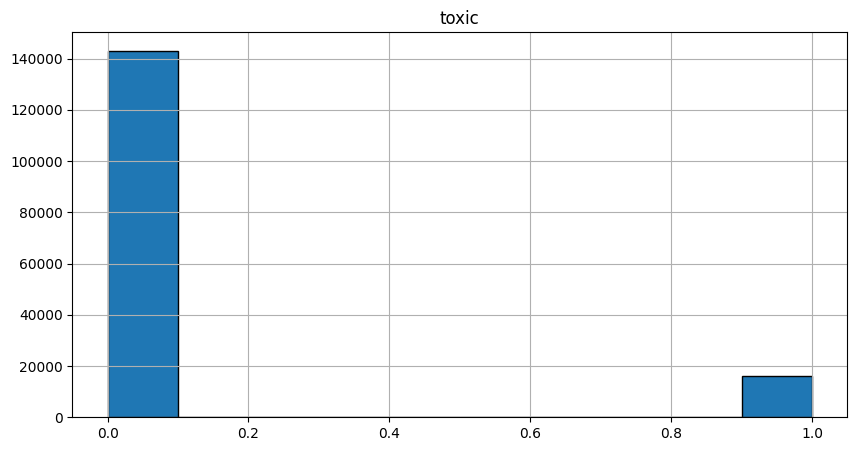

In [6]:
df_info(data)

Итак, просмотрим нанаши данные. Всего 3 столбца, из них столбец toxic будет целевым признаком. Тип данных верный, пропусков нет, дубликатов тоже. Ярко выраженной корреляции также не наблюдается, что и логично. Для дальнейшей работы необходимо привести текст в нужный нам формат, для этого мы совершим токенизацию каждого твита и лемматизацию. 

In [7]:
# Cоздаем функцию обработки текстов
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words_eng =stopwords.words('english')
stop_words_eng.remove('not')

m = WordNetLemmatizer()


# Функция по очистке текста
def clear_text(text):
    text = text.lower()
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

# Создадим функцию которая будет использовать функцию по очистке слов и лемматизировать каждое слово
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Функция по лемматизации
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=m.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
#import spacy
#nlp = spacy.load('en', disable=['parser', 'ner'])
#sentence = data['text']
#doc = nlp(sentence)

#data['lemma_text'] = " ".join([token.lemma_ for token in doc])
# 

In [9]:
tqdm.pandas()
# Проведем нашу очистку  

data['lemm_text'] = data['text'].progress_apply(lambda i: lemmafunction(clear_text(i))) 

# выводим данные и информацию
display(data.head())
display(data.shape)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


(159292, 3)

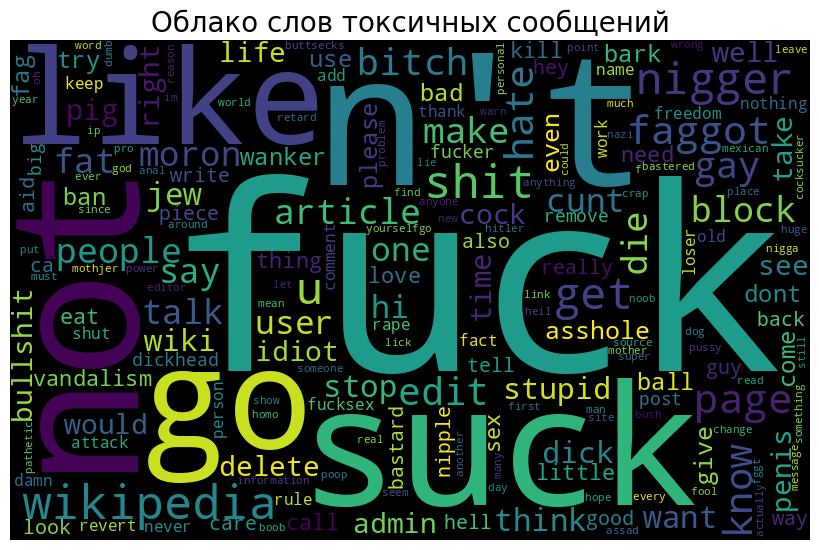

In [10]:
# Визуализируем облако слов в текстах с токсичной коннотацией 
words_list = data[data['toxic']==1]['lemm_text'].unique().tolist()
pos_words = " ".join(words_list)
 
pos_wordcloud =  WordCloud(width=800, height = 500, collocations=False,             
                  stopwords=stop_words_eng).generate(pos_words)
 
plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Облако слов токсичных сообщений', fontsize=20);

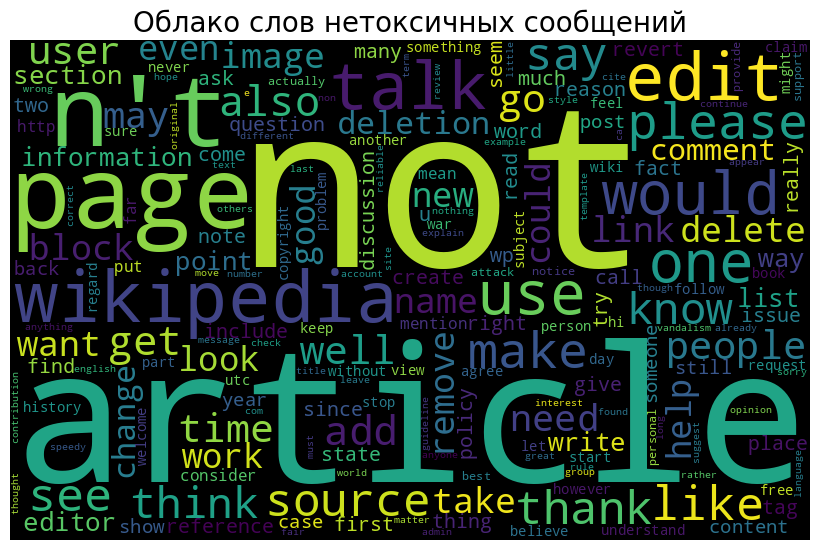

In [11]:
# Визуализируем облако слов в текстах с нетоксичной коннотацией 
words_list = data[data['toxic']==0]['lemm_text'].unique().tolist()
pos_words = " ".join(words_list)
 
pos_wordcloud =  WordCloud(width=800, height = 500, collocations=False,            
                  stopwords=stop_words_eng).generate(pos_words)
 
plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Облако слов нетоксичных сообщений', fontsize=20);

 ## Обучение

Перед тем как обучать модель, проверим баланс классов и удалим неинформативные признаки

In [12]:
display(data['toxic'].value_counts())

class_ratio = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
print('Соотношение целевых признаков', class_ratio)

0    143106
1     16186
Name: toxic, dtype: int64

Соотношение целевых признаков 8.841344371679229


Здесь явный дисбаланс классов, так что надо сделать балансировку в дальнейшем. А пока разделим наши данные на выборки.

In [13]:
RANDOM = 12345
# Выделим целевой признак и признаки
features = data.drop(['toxic', 'text'], axis=1)
target = data['toxic']

# Разделим на выборки обучающую и тестовую в соотношении 3:1
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state = RANDOM, stratify = target)

# Проверим размер выборок 
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(119469, 1)
(39823, 1)
(119469,)
(39823,)


Так как у нас присутствует дисбаланс классов, то мы напишем функцию для ее устранения. В данном случае, применим метод  class_weight в моделях.

In [14]:
# Напишем функцию увеличения выборок
#def upsample (features, target, repeat):

#  features_zeros = features[target==0]
#  features_one = features[target==1]
#  target_zeros = target[target==0]
#  target_one = target[target==1]

#  features_upsampled = pd.concat([features_zeros] + [features_one]*repeat)
#  target_upsampled = pd.concat([target_zeros] + [target_one]*repeat)
#  features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled)

#  return features_upsampled, target_upsampled


In [15]:
# Применим функцию к обучающей выборке
#features_train, target_train = upsample(features_train, target_train, repeat=6)

#print(features_train.shape)
#print(target_train.shape)

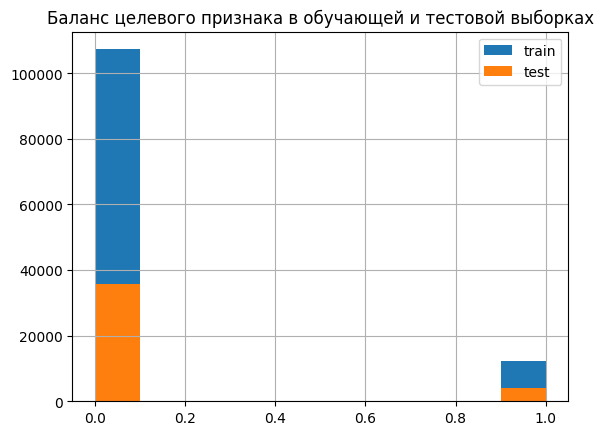

In [16]:
# проверяем баланс целевых переменных
target_train.hist(label='train')
target_test.hist(label='test')
plt.legend()
plt.title('Баланс целевого признака в обучающей и тестовой выборках');

### Выбор метода векторизации

Для того, чтобы модель смогла обучиться, нужно преобразовать слова в вектор. Мы выберем самую подходящую для нас метод из нескольких: "мешок слов" с разным размером N-грамм, или TF-IDF. Испробуем их на модели Логистической Регрессии

In [17]:
# Метод CountVectorizer

# создаем переменные корпусов
corpus_train = features_train['lemm_text'].values
corpus_test = features_test['lemm_text'].values


# Инициируем модель
count_vect = CountVectorizer()
bow = count_vect.fit_transform(corpus_train)
print(bow.shape)

(119469, 128176)


In [18]:
# Применим на модели LogisticRegression
cv=5
scoring = 'f1'
class_weight='balanced'

model_lr=LogisticRegression(random_state = RANDOM, solver = 'liblinear', class_weight=class_weight)
scores = cross_val_score(model_lr, bow, target_train, cv=cv, scoring=scoring)
print('Взвешенная метрика F1 по результатам кросс-валидации, логистическая регрессия:', scores.mean().round(4))

Взвешенная метрика F1 по результатам кросс-валидации, логистическая регрессия: 0.7446


In [19]:
# Испытаем метод TfidfVectorizer
count_tf_idf = TfidfVectorizer()
tf_idf_train = count_tf_idf.fit_transform(features_train.lemm_text)
display(tf_idf_train.shape)

(119469, 128176)

In [20]:
%%time
# Испытаем на модели
model = LogisticRegression(random_state=RANDOM, class_weight = class_weight)
scores_tf = cross_val_score(model, tf_idf_train, target_train, cv=cv, scoring=scoring)
print('Взвешенная метрика F1 по результатам кросс-валидации, tfidf:', scores_tf.mean().round(4))

Взвешенная метрика F1 по результатам кросс-валидации, tfidf: 0.7507
CPU times: user 49.6 s, sys: 54 s, total: 1min 43s
Wall time: 1min 4s


По нашим результатам можно сделать вывод, что метод TF-IDF работает лучше, так что именно его мы используем на обучении.

In [21]:
# Проведем векторизацию выбранным методом на признаках
features_train = count_tf_idf.fit_transform(corpus_train)
features_test = count_tf_idf.transform(corpus_test)


### Выбор модели

Мы испытаем несколько моделей, по классике возьмем Логистическую регрессию и Случайный лес. Из сложных моделей возьмем CatBoost и LightGBM. Наша задача, вывести метрику F1 не менее 0.75.

In [22]:
# Создадим функцию, которая сохранит результаты моделей
#class ModelHelper:
#    def __init__(self, name, model):
#        self.name = name
#        self.model = model
    
#    def fit(self, features, target):        
#        self.model.fit(features, target)
            
#    def predict(self, features, target):          
#        predicted = self.model.predict(features)   
#        self.f1 = f1_score(target, predicted)
    
#    def getResult(self):
#        return self.name, self.f1
    
    
# Создадим переменную, где будут храниться результаты
#result = []

# И создадим функцию для красивого вывода
#def print_result(result):
#    print('|{: >20}|{: >12}|'.format('Модель', 'F-1'))
#    for info in result:
#        print('|{: >20}|{: >12.5f}|'.format(info[0], info[1]))    

In [23]:
%%time
# Начнем с модели LogisticRegression
imba_pipeline = make_pipeline(LogisticRegression(random_state=RANDOM, class_weight = class_weight))

log_params = {'logisticregression__C': [0.1, 10.], 'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg']}
clf_log = GridSearchCV(imba_pipeline, param_grid = log_params, scoring=scoring, cv=cv, refit=True, n_jobs=-1)
clf_log.fit(features_train, target_train)
clf_log.best_params_

CPU times: user 12.5 s, sys: 11.3 s, total: 23.8 s
Wall time: 2min 45s


{'logisticregression__C': 10.0, 'logisticregression__solver': 'lbfgs'}

In [25]:
# Проверим лучшую метрику
clf_log.best_score_

0.7759360502600753

In [27]:
model_lr = clf_log.best_estimator_
model_lr.fit(features_train, target_train)
predicted_lr= model_lr.predict(features_train)
print(f1_score(target_train, predicted_lr))

0.9088517196015786


In [33]:
%%time
# Попробуем обучить случайный лес
rf_pipeline = make_pipeline(RandomForestClassifier(random_state=RANDOM, class_weight = class_weight))

parameters = {'randomforestclassifier__n_estimators': [5,7,9],'randomforestclassifier__max_depth': [1,5,8]}
 
grid_rfr = GridSearchCV(rf_pipeline, param_grid = parameters, cv=cv, scoring=scoring)
grid_rfr.fit(features_train, target_train)

grid_rfr.best_params_


{'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__n_estimators': 7}

In [34]:
# посмотрим метрику
grid_rfr.best_score_

0.2868906482916108

In [36]:
#%%time
# Перейдем к моделям бустинга. LighnGBM
#gbm_pipeline = make_pipeline(LGBMClassifier(random_state=RANDOM, class_weight = class_weight, boosting_type='gbdt'))

#gbm_params = {'lgbmclassifier__learning_rate': [0.1, 0.01], 'lgbmclassifier__n_estimators': [20, 50, 100], 'lgbmclassifier__max_depth': [4,6]}
#grid_gbm = GridSearchCV(gbm_pipeline, param_grid= gbm_params, cv=cv, scoring=scoring)
#grid_gbm.fit(features_train, target_train)

#grid_gbm.best_params_

KeyboardInterrupt: ignored

In [ ]:
#grid_gbm.best_score_

In [39]:
%%time
# Обучим модель
model_gbm = LGBMClassifier(class_weight= class_weight, boosting_type='gbdt', seed=RANDOM, learning_rate = 0.1, n_estimators = 100, max_depth = 4)
model_gbm.fit(features_train, target_train)
predict_gbm = model_gbm.predict(features_test)
f1_gbm = f1_score(target_test, predict_gbm)
print('F1', f1_gbm)

F1 0.6247150926568229
CPU times: user 1min 8s, sys: 295 ms, total: 1min 8s
Wall time: 1min 8s


In [40]:
# Перейдем к моделе CatBoost
#cb_pipeline = make_pipeline(CatBoostClassifier(random_state=RANDOM, class_weight = class_weight, loss_function='Logloss'))
#
#cb_params = {'depth':[3, 15],
 #             'iterations':[10, 30],
  #            'learning_rate':[0.03, 0.3]}

#grid_сb = GridSearchCV(cb_pipeline, cb_params, cv=cv, scoring=scoring)
#grid_сb.fit(features_train, target_train);

#grid_сb.best_params_

In [43]:
# Тоже модель долго обучалась, ввела гиперпараметры сама

# Обучим модель
model_cb = CatBoostClassifier(random_state=RANDOM, loss_function='MultiClass', depth= 3, iterations = 10, learning_rate= 0.03)
model_cb.fit(features_train, target_train)
predict_cbc = model_cb.predict(features_test)
f1_cb = f1_score(target_test, predict_cbc)
print('F1', f1_cb)


0:	learn: 0.6714949	total: 1.57s	remaining: 14.1s
1:	learn: 0.6511473	total: 2.99s	remaining: 11.9s
2:	learn: 0.6319322	total: 4.43s	remaining: 10.3s
3:	learn: 0.6136767	total: 5.8s	remaining: 8.7s
4:	learn: 0.5967968	total: 7.19s	remaining: 7.19s
5:	learn: 0.5807990	total: 9.19s	remaining: 6.13s
6:	learn: 0.5655597	total: 11.6s	remaining: 4.97s
7:	learn: 0.5508697	total: 13.4s	remaining: 3.34s
8:	learn: 0.5371880	total: 14.7s	remaining: 1.64s
9:	learn: 0.5239423	total: 16.1s	remaining: 0us
F1 0.4208083542835041


In [44]:
# Посмотрим наши предварительные результаты
comparison_tabl = pd.DataFrame(index=['F1-мера'], columns=['LogisticRegression','RandomForestClassifier','LGBMClassifier','CatBoostClassifier'])
comparison_tabl['LogisticRegression'] = clf_log.best_score_
comparison_tabl['RandomForestClassifier'] = grid_rfr.best_score_
comparison_tabl['LGBMClassifier'] = f1_gbm 
comparison_tabl['CatBoostClassifier'] = f1_cb
comparison_tabl.T

,F1-мера
LogisticRegression,0.775936
RandomForestClassifier,0.286891
LGBMClassifier,0.624715
CatBoostClassifier,0.420808


Модель Logistic regression показала самый лучший результат. Значит испытаем тестовую выборку именно на ней

## Тестирование

Мы отобрали лучшую модель для обучения, Logistic regression. Далее мы испытаем ее на тестовой выборке

In [45]:
# Лучшие гиперпараметры для модели {'logisticregression__C': 10.0, 'logisticregression__solver': 'lbfgs'}
model_test = clf_log.best_estimator_
predict_test = model_test.predict(features_test)
print('F1-test', f1_score(target_test, predict_test))

F1-test 0.7762317518248175


## Выводы

На начальном этапе, мы провели векторизацию текста, для этого испробовав 2 метода, и остановились на методе TF-IDF.

Далее мы также решили выбрать наилучшую модель для нашей задачи классификации. Выбор остановили на стандартных LogisticRegression и RandomForestClassifier.
Из более сложный моделей мы выбрали LGBMClassifier и CatBoostClassifier.

Для выбора лучшей модели мы отобрали метрику F1>0.75. Вот наши результаты:

                      	     F1-мера
     LogisticRegression	     0.775936
     RandomForestClassifier	 0.286891
     LGBMClassifier       	 0.624715
     CatBoostClassifier   	 0.420808

Так как модель  LightGBM тратит много времени на обучение, и ее показатель метрики все равно низкий, то мы естественно остановились на модели Logistic regression. На данной моделе провели тестирование, и результаты нас удовлетворили:

      Logistic regression test|     0.7762|

Мы смогли выполнить задачу, и обучили модель классифицировать комментарии на позитивные и негативные.      